In [1]:
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from pennylane.optimize import AdamOptimizer
import tensorflow as tf

In [2]:
# A network with one neuron
structure = [1]

# Initialize the device with a dynamic number of wires
num_qubits = sum(structure) + 3  # 2(input qubit) + 1(label qubit)
dev = qml.device("default.qubit", wires=num_qubits)

In [3]:
def qn_RY(paras, control_q, ancila):
    for i in range(len(control_q)):
        qml.CRY(paras[i], wires=[control_q[i], ancila])
    qml.RZ(paras[len(control_q)], ancila)
    qml.RY(paras[len(control_q)+1], ancila)

In [4]:
@qml.qnode(dev, interface="autograd")
def circuit(paras, f, label=None, structure=structure, input_type="individual"):
    gate_params = 2

    # Embedding the initial state based on the input type
    if input_type == "individual":
        qml.AmplitudeEmbedding(features=f, wires=list(range(2)), normalize=True)
    elif input_type == "superposition":
        qml.AmplitudeEmbedding(features=f, wires=list(range(2)) + [3], normalize=True)

    # Prepare parameters
    idx = 0
    ancila_start = 2
    control_q = [0, 1] # input quibit

    for num_neurons in structure:
        new_control_q = []
        for _ in range(num_neurons):
            qn_RY(paras[idx:idx+len(control_q)+gate_params], control_q, ancila_start)
            idx += len(control_q) + gate_params
            new_control_q.append(ancila_start)
            ancila_start += 1
        control_q = new_control_q

    # Apply a Pauli-X gate if label is 1
    if label==1:
        qml.PauliX(wires=ancila_start)

    return qml.expval(qml.PauliZ(ancila_start - 1) @ qml.PauliZ(ancila_start))

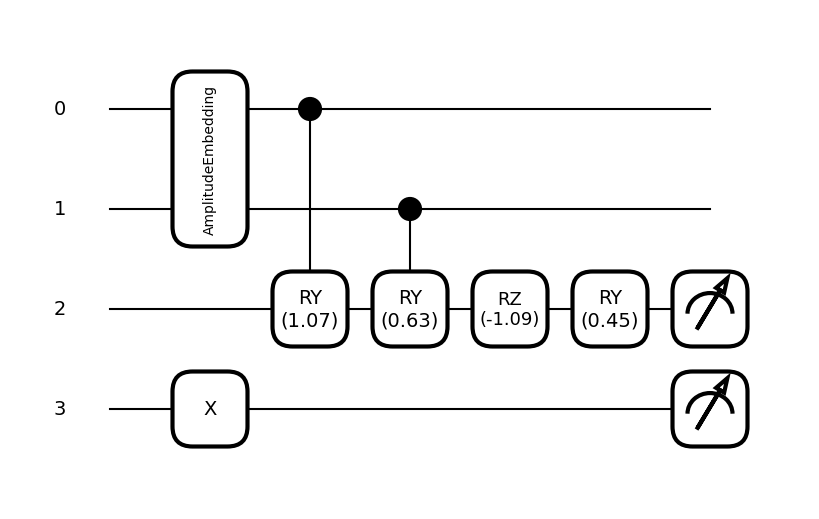

In [5]:
# Random initialization of parameters for U3
paras_init = np.random.randn(4)

# Draw the executed quantum circuit:
fig, ax = qml.draw_mpl(circuit, decimals=2)(paras_init,
                                            label=1, f=np.random.randn(4))
plt.show()

In [6]:
def sum_loss(predictions):
    loss = - (np.sum(predictions) / len(predictions)) 
    return loss

def accuracy(predictions):
    acc = 0
    for p in predictions:
        if p > 0:
            acc = acc + 1
    acc = acc / len(predictions)
    return acc

def cost(paras, features, labels):
    predictions = [circuit(paras, f, label) for (f, label) in zip (features, labels)]
    return sum_loss(predictions)

def cost_s(paras, features):
    prediction = [circuit(paras, f=features, input_type="superposition")]
    return sum_loss(prediction)

In [7]:
data = np.loadtxt("data/iris_classes1and2.txt")
features = data[:, 0:4]

Y = data[:, -1]
Y = (Y + 1)/2

In [8]:
np.random.seed(7)
num_data = len(Y)
num_train = int(0.5 * num_data)
index = np.random.permutation(range(num_data))
x_train = features[index[:num_train]] 
y_train = Y[index[:num_train]]
x_test = features[index[num_train:]]
y_test = Y[index[num_train:]]

In [9]:
# Counting the number of 1s and 0s
count_ones = tf.reduce_sum(tf.cast(tf.equal(y_test, 1), tf.int32))
count_zeros = tf.reduce_sum(tf.cast(tf.equal(y_test, 0), tf.int32))

# Printing the counts
print("Number of 1s:", count_ones)
print("Number of 0s:", count_zeros)

Number of 1s: tf.Tensor(25, shape=(), dtype=int32)
Number of 0s: tf.Tensor(25, shape=(), dtype=int32)


In [10]:
opt = AdamOptimizer(0.05)
batch_size = len(x_train)
num_batches = num_train // batch_size  # Determine number of batches
num_epochs = 50

# train the variational classifier
paras = paras_init
cost_test_i, acc_test_i = [], []
cost_train_i, acc_train_i = [], []

paras_s = paras_init
cost_test_sup, acc_test_sup = [], []
cost_train_sup, acc_train_sup = [], []

for epoch in range(num_epochs):
    for batch_idx in range(num_batches):
        # Compute start and end indices for batch
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        # If end index goes beyond the number of training samples, clip it
        if end_idx > num_train:
            end_idx = num_train

        # Update the paras by one optimizer step
        x_train_batch = x_train[start_idx:end_idx]
        y_train_batch = y_train[start_idx:end_idx]
        paras = opt.step(lambda v: cost(v, x_train_batch, y_train_batch), paras)

        # Get the samples where Y_train equals 1 and sum them
        x_train_1 = x_train_batch[y_train_batch == 1]
        sum_x_train_1 = np.sum(x_train_1, axis=0)  # Sum over samples
        # Get the samples where Y_train equals 0 and sum them
        x_train_0 = x_train_batch[y_train_batch == 0]
        sum_x_train_0 = np.sum(x_train_0, axis=0)  # Sum over samples

        # creat the superposition state
        feats_train_batch_s = []
        for i in range(x_train_1.shape[1]):
            feats_train_batch_s.append(sum_x_train_0[i])
            feats_train_batch_s.append(sum_x_train_1[i])

        paras_s = opt.step(lambda v: cost_s(v, feats_train_batch_s), paras_s)


    # Compute predictions on train and validation set
    predictions_train = [circuit(paras, f, label) for (f, label) in zip (x_train, y_train)]
    predictions_test = [circuit(paras, f, label) for (f, label) in zip (x_test, y_test)]
    
    # Compute accuracy on train and test set
    acc_train = accuracy(predictions_train)
    acc_test = accuracy(predictions_test)
    acc_train_i.append(acc_train)
    acc_test_i.append(acc_test)

    cost_train = sum_loss(predictions_train)
    cost_test = sum_loss(predictions_test)
    cost_train_i.append(cost_train)
    cost_test_i.append(cost_test)
    print("----------")
    print(
        "Iter: {:5d} | Cost train: {:0.7f} | Cost test: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
        "".format(epoch + 1, cost_train, cost_test, acc_train, acc_test)
    )

    # Superposition 
    predictions_train = [circuit(paras_s, f, label) for (f, label) in zip (x_train, y_train)]
    predictions_test = [circuit(paras_s, f, label) for (f, label) in zip (x_test, y_test)]
    
    acc_train = accuracy(predictions_train)
    acc_test = accuracy(predictions_test)
    acc_train_sup.append(acc_train)
    acc_test_sup.append(acc_test)

    cost_train = sum_loss(predictions_train)
    cost_test = sum_loss(predictions_test)
    cost_train_sup.append(cost_train)
    cost_test_sup.append(cost_test)
    print(
        "Iter: {:5d} | Cost train: {:0.7f} | Cost test: {:0.7f} | Acc train: {:0.7f} | Acc test: {:0.7f} "
        "".format(epoch + 1, cost_train, cost_test, acc_train, acc_test)
    )
    

----------
Iter:     1 | Cost train: -0.1652465 | Cost test: -0.1790063 | Acc train: 0.5000000 | Acc test: 0.5000000 
Iter:     1 | Cost train: -0.1594446 | Cost test: -0.1729181 | Acc train: 0.5000000 | Acc test: 0.5000000 
----------
Iter:     2 | Cost train: -0.1881888 | Cost test: -0.2031512 | Acc train: 0.5000000 | Acc test: 0.5000000 
Iter:     2 | Cost train: -0.1806976 | Cost test: -0.1953140 | Acc train: 0.5000000 | Acc test: 0.5000000 
----------
Iter:     3 | Cost train: -0.2109701 | Cost test: -0.2271357 | Acc train: 0.5000000 | Acc test: 0.5000000 
Iter:     3 | Cost train: -0.2021588 | Cost test: -0.2179221 | Acc train: 0.5000000 | Acc test: 0.5000000 
----------
Iter:     4 | Cost train: -0.2338048 | Cost test: -0.2511783 | Acc train: 0.5000000 | Acc test: 0.5000000 
Iter:     4 | Cost train: -0.2237284 | Cost test: -0.2406372 | Acc train: 0.5400000 | Acc test: 0.6400000 
----------
Iter:     5 | Cost train: -0.2567013 | Cost test: -0.2752849 | Acc train: 0.5400000 | Acc

In [11]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(4, 1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.05),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

# Train the model
nn_history = model.fit(x_train,
                       y_train,
                       batch_size=len(x_train),
                       epochs=50, 
                       validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - 0s 470ms/step - loss: 0.7775 - accuracy: 0.5000 - val_loss: 0.7406 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 28ms/step - loss: 0.7434 - accuracy: 0.5000 - val_loss: 0.7094 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 34ms/step - loss: 0.7101 - accuracy: 0.5000 - val_loss: 0.6790 - val_accuracy: 0.5000
Epoch 4/50
1/1 [========================

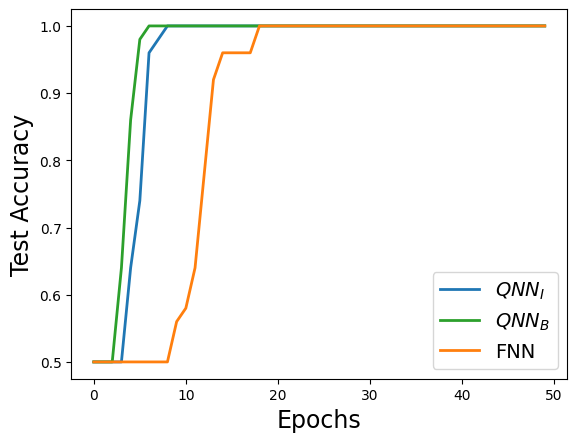

In [12]:
plt.figure().add_subplot()
plt.xlabel('Epochs', fontsize=17)
plt.ylabel('Test Accuracy', fontsize=17)
plt.plot(acc_test_i, color='C0',label='$QNN_I$', linewidth=2)
plt.plot(acc_test_sup, color='C2',label='$QNN_B$', linewidth=2)
plt.plot(nn_history.history['val_accuracy'], color='C1',label='FNN', linewidth=2)
plt.legend(fontsize=14)

In [ ]:
def save_data(acc_test_i, acc_test_sup, FNN_test):
    data_dict = {
        "acc_test_i": acc_test_i,
        "acc_test_sup": acc_test_sup,
        "FNN_test": FNN_test
    }

    with open("iris_loss.txt", "a") as file:
        for label, data_list in data_dict.items():
            file.write(label + ':' + ','.join(map(str, data_list)) + '\n')

# Save data
save_data(acc_test_i, acc_test_sup, nn_history.history['val_accuracy'])